In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
from scipy import signal

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
'''
数据读取与处理
'''

'\n数据读取与处理\n'

In [3]:
start = '2005-02-01'
end = '2019-06-30'

In [4]:
# MacroList = ['PMI', 'CPI:当月同比', 'PPI:全部工业品:当月同比', '工业增加值:当月同比', 'M2:同比','长短期利差', '信用利差','利率']
# MacroList = ['PMI', 'PPI:全部工业品:当月同比']
MacroList = ['PMI', 'PPI:全部工业品:当月同比']
# MacroList = ['利率', '信用利差']
# AssetList = ['沪深300','南华商品指数','中证全债','货币基金']
# AssetList = ['沪深300','南华商品指数','SGE黄金9999','中证全债']
AssetList = ['沪深300','南华商品指数','中证全债']
# AssetList = ['沪深300','中证全债']

In [5]:
AssetPrice = pd.read_excel('C:/Users/Thinkpad/Desktop/大类资产数据.xlsx').set_index('date').fillna(method='bfill')[AssetList]
AssetReturn = AssetPrice.pct_change().dropna()

In [6]:
MacroData = pd.read_excel('C:/Users/Thinkpad/Desktop/原电脑桌面/宏观经济指标数据.xlsx').set_index('date')
MacroData['长短期利差'] = MacroData['中债国债到期收益率:10年'] - MacroData['中债国债到期收益率:1年']
MacroData['信用利差'] = MacroData['中债企业债到期收益率(AA):1年'] - MacroData['中债企业债到期收益率(AAA):1年']
MacroData['利率'] = MacroData['中债国债到期收益率:1年']
MacroData = MacroData.fillna(method='bfill')
MacroData_ = MacroData[MacroList].copy()
MacroData_M = MacroData_.apply(lambda x:x.resample("M").last())
MacroData_M_Lag1 = MacroData_M.copy()
# for col in ['PMI', 'CPI:当月同比', 'PPI:全部工业品:当月同比', '工业增加值:当月同比', 'M2:同比']:
for col in [each for each in MacroList if each not in ['长短期利差', '信用利差','利率']]:
    MacroData_M_Lag1[col] = MacroData_M[col].shift(1)
MacroData_M_Lag1 = MacroData_M_Lag1.dropna()

In [1175]:
'''
HP 滤波处理 - 临时（全局）
'''

'\nHP 滤波处理 - 临时（全局）\n'

In [355]:
# b, a = signal.butter(2, [0.2,0.8], 'bandpass')   #配置滤波器 8 表示滤波器的阶数
# filtedData = signal.filtfilt(b, a, MacroData_M_Lag1[MacroList[0]])  #data为要过滤的信号
# MacroData_M_Lag1[MacroList[0]] = MacroData_M_Lag1[MacroList[0]]-filtedData

# filtedData = signal.filtfilt(b, a, MacroData_M_Lag1[MacroList[1]])  #data为要过滤的信号
# MacroData_M_Lag1[MacroList[1]] = MacroData_M_Lag1[MacroList[1]]-filtedData

In [1177]:
'''
数据重采样 - 日度数据月度化
'''

'\n数据重采样 - 日度数据月度化\n'

In [7]:
AssetPriceM = AssetPrice.copy()
AssetPriceM['trade_date'] = AssetPriceM.index
AssetPriceM = AssetPriceM.apply(lambda x: x.resample('M').last()).copy().set_index('trade_date')
AssetReturnM = AssetPriceM.pct_change().dropna()

In [8]:
AssetPriceM = AssetPriceM[(AssetPriceM.index>=start) & (AssetPriceM.index<=end)].copy()
AssetReturn = AssetReturn[(AssetReturn.index>=start) & (AssetReturn.index<=end)].copy()
AssetReturnM = AssetReturnM[(AssetReturnM.index>=start) & (AssetReturnM.index<=end)].copy()
MacroData_M_Lag1 = MacroData_M_Lag1[(MacroData_M_Lag1.index>=start) & (MacroData_M_Lag1.index<=end)].copy()

In [9]:
MacroData_M_Lag1.index = AssetPriceM.index

In [1183]:
'''
经济周期划分 - 美林时钟体系
'''

'\n经济周期划分 - 美林时钟体系\n'

In [10]:
## 货币信用周期指标1 - T~T-3正负占比
def MLcycle(series):
    MList = series.tolist()
    MResultTmp = []
    for i in range(len(MList)-1):
        if MList[-1]-MList[i]>=0:
            MResultTmp.append(1)
        else:
            MResultTmp.append(-1)
    MResult = np.sum(MResultTmp)
    if MResult>0:
        result = 1
    else:
        result = 0
    return result

In [11]:
lag_M = 6
MLcycleDf = MacroData_M_Lag1.rolling(lag_M).apply(MLcycle,raw=True).dropna()
MLcycleDf['MLcycle'] = MLcycleDf.apply(lambda x: str(int(x[MacroList[0]]))+str(int(x[MacroList[1]])),axis=1)

F:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


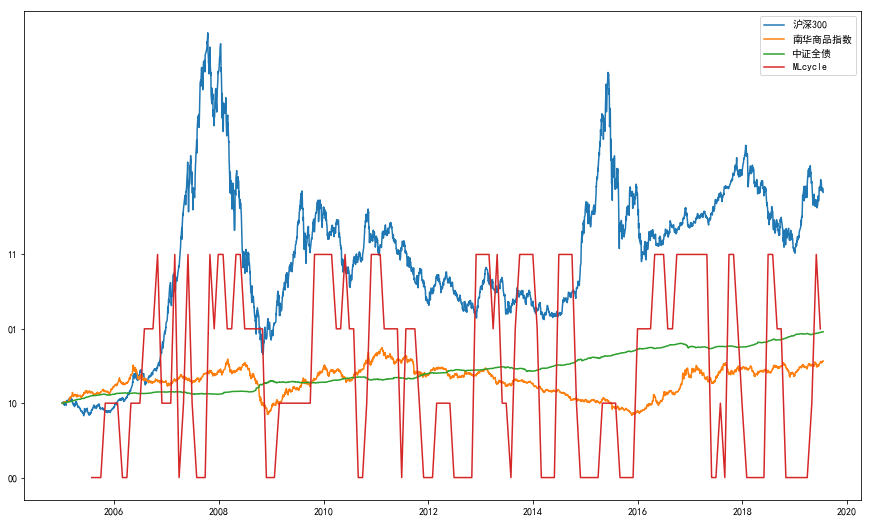

In [12]:
plt.figure(figsize=(15,9))
for col in AssetList:
    plt.plot(AssetPrice[col]/AssetPrice[col].tolist()[0],label=col)
plt.plot(MLcycleDf['MLcycle'])
plt.legend(loc=0)
plt.show()

In [13]:
# 重要输出，周期与对应资产收益
MLcycleDfwithReturn = MLcycleDf[['MLcycle']].merge(AssetReturnM.shift(0),left_index=True,right_index=True,how='left')

In [14]:
MLcycleDfwithReturn.groupby('MLcycle').mean()*12

,沪深300,南华商品指数,中证全债
MLcycle,,,
00,0.293527,0.025176,0.063086
01,-0.436122,-0.124431,0.071326
10,0.611852,0.122302,0.022774
11,0.085017,0.098589,0.013153


In [15]:
MLcycleDfwithReturn.groupby('MLcycle').std()

,沪深300,南华商品指数,中证全债
MLcycle,,,
00,0.075096,0.033575,0.007292
01,0.093105,0.058125,0.010613
10,0.108504,0.039890,0.007565
11,0.062512,0.049553,0.007093


In [16]:
(MLcycleDfwithReturn.groupby('MLcycle').mean()*12-0.03)/(MLcycleDfwithReturn.groupby('MLcycle').std()*np.sqrt(12))

,沪深300,南华商品指数,中证全债
MLcycle,,,
00,1.013025,-0.041479,1.309756
01,-1.445226,-0.766976,1.124082
10,1.548021,0.667963,-0.275716
11,0.254068,0.399571,-0.685647


In [17]:
(MLcycleDfwithReturn.groupby('MLcycle').mean()*12)/(MLcycleDfwithReturn.groupby('MLcycle').std()*np.sqrt(12))

,沪深300,南华商品指数,中证全债
MLcycle,,,
00,1.128348,0.216459,2.497350
01,-1.352210,-0.617982,1.940091
10,1.627836,0.885065,0.869021
11,0.392607,0.574338,0.535276


In [1191]:
'''
策略部分
'''

'\n策略部分\n'

In [18]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-rf)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

In [30]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:strategy_name})
    # 最大回撤结束、开始时间，持续时长
    max_drawdown_end = df['drawdown'].idxmax()
    max_drawdown_end_str = max_drawdown_end.strftime('%Y-%m-%d')
    df_before_max_drawdowm = df[df.index<=max_drawdown_end].copy()
    max_drawdown_start = df_before_max_drawdowm[df_before_max_drawdowm['drawdown'] == 0].index[-1]
    max_drawdown_start_str = max_drawdown_start.strftime('%Y-%m-%d')
    max_drawdown_year = (max_drawdown_end - max_drawdown_start).days/365.25

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                   'max_drawdown_start':[max_drawdown_start_str],
                   'max_drawdown_end':[max_drawdown_end_str],
                   'max_drawdown_last_Y':[max_drawdown_year],
                  }
    output_df = pd.DataFrame(output_dict,index=[strategy_name]).T
    return output_df, df, df_return_per_year

In [20]:
### 胜率计算函数 
def WinProb(Dict,bechmark):
    EquityAllDF = pd.DataFrame()
    for key in Dict.keys():
        EquityDF = Dict[key].copy()
        EquityDF.columns = [key]
        EquityAllDF = pd.concat([EquityAllDF,EquityDF],axis=1)
    EquityAllDF_WIN = EquityAllDF.apply(lambda x: x.resample('M').last()).pct_change().dropna()
    for col in EquityAllDF_WIN.columns:
        EquityAllDF_WIN[col] = EquityAllDF_WIN[col].apply(lambda x: 1 if x>0 else 0)
    WIN = (EquityAllDF_WIN.sum()/len(EquityAllDF_WIN)).to_frame('绝对胜率').T
    
    rEquityAllDF = pd.DataFrame()
    for rkey in [each for each in Dict.keys() if each != bechmark]:
        rEquityDF = (Dict[rkey][Dict[rkey].columns[0]]/Dict[bechmark][Dict[bechmark].columns[0]]).to_frame(rkey)
        rEquityDF.columns = [rkey]
        rEquityAllDF = pd.concat([rEquityAllDF,rEquityDF],axis=1)
    rEquityAllDF_WIN = rEquityAllDF.apply(lambda x: x.resample('M').last()).pct_change().dropna()
    for rcol in rEquityAllDF_WIN.columns:
        rEquityAllDF_WIN[rcol] = rEquityAllDF_WIN[rcol].apply(lambda x: 1 if x>0 else 0)
    rWIN = (rEquityAllDF_WIN.sum()/len(rEquityAllDF_WIN)).to_frame('相对胜率').T
    return WIN, rWIN

In [21]:
### 周期下权重计算函数，夏普比率加权，年化rf = 0.03
def ComputeWeight(MLcycleDfwithReturn):
    if WeightKIND == 'Sharpe':
        IRdf = (MLcycleDfwithReturn.groupby('MLcycle').mean()*12-rf)/(MLcycleDfwithReturn.groupby('MLcycle').std()*np.sqrt(12))
    if WeightKIND == 'Return':
        IRdf = MLcycleDfwithReturn.groupby('MLcycle').mean()*12
    if WeightKIND == 'IR':
        IRdf = (MLcycleDfwithReturn.groupby('MLcycle').mean()*12)/(MLcycleDfwithReturn.groupby('MLcycle').std()*np.sqrt(12))
    if WeightKIND == 'Unity':
        IRdf = MLcycleDfwithReturn.groupby('MLcycle').mean()*12 - MLcycleDfwithReturn.groupby('MLcycle').var()*12
    df = IRdf.copy().T
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x if x>0 else 0)
        if np.sum(df[col]) == 0:
            df[col] = [0]*(len(AssetList)-1)+[1]
        else:
            df[col] = df[col]/np.sum(df[col])
    return df.T

In [22]:
### 风险平价系列函数

# 组合风险函数，输出 1x1
def PortfolioVar(w,V):
    return np.dot(np.dot(w,V),np.transpose(w))

# 各资产边际风险贡献，输出 Nx1
def RiskContribution(w,V):
    sigma_p = np.sqrt(PortfolioVar(w,V))
    MRC = np.dot(V,np.transpose(w))/sigma_p
    RC = np.multiply(MRC,np.transpose(w))
    return RC

# 风险平价目标函数
def RiskParity(w):
    sigma_p = np.sqrt(PortfolioVar(w,V))
    N = len(w)
    V_w = np.dot(V,np.transpose(w))
    J_list = []
    for i in range(N):
        item_i = w[i]*V_w[i]
        for j in range(N):
            item_j = w[j]*V_w[j]
            J_list.append(np.square(item_j-item_i))
    J = np.sum(J_list)
    return J

# 优化求解目标权重w
def CalculateW(V):
    # 资产数量
    N = len(V)
    # 初始权重
    w0 = [1/N for each in range(N)]
    # 约束
    def WeightConstranit1(w):
        return np.sum(w)-1
    def WeightConstranit2(w):
        return w
    cons = ({'type':'eq','fun':WeightConstranit1},{'type':'ineq','fun':WeightConstranit2})
    optimize_fun = sco.minimize(RiskParity,w0,method='SLSQP',constraints=cons)
    w_best = optimize_fun['x']
    return list(w_best)

In [22]:
'''
策略1 - 周期资产配置轮动，不预测，以当前判断出的周期作为下一个周期
'''

'\n策略1 - 周期资产配置轮动，不预测，以当前判断出的周期作为下一个周期\n'

In [23]:
CycleList = ['00','01','10','11']
CycleDict = {'00':'经济下行 通胀下行','01':'经济下行 通胀上行','10':'经济上行 通胀下行','11':'经济上行 通胀上行'}

In [71]:
### 策略函数
def Strategy(cycle_now):
    '''
    输入历史行情收益率数据，计算协方差矩阵
    输出所有资产对应目标权重
    '''
    if method != '等权重':
        MLcycleDfwithReturnSub = MLcycleDfwithReturnDict[strategy_date].copy()
        cycle = ComputeWeight(MLcycleDfwithReturnSub)
        # 股票 商品 债券 货币
        w_list_00 = cycle.loc['00',].tolist()
        w_list_01 = cycle.loc['01',].tolist()
        w_list_10 = cycle.loc['10',].tolist()
        w_list_11 = cycle.loc['11',].tolist()
        
        if cycle_now == '00':
            w_list = w_list_00
        if cycle_now == '01':
            w_list = w_list_01
        if cycle_now == '10':
            w_list = w_list_10
        if cycle_now == '11':
            w_list = w_list_11
    
    if method == '等权重':
        N = len(AssetList)
        w_list = [1/N for i in range(N)]
    
    if method == '固定权重':
        w_list = [0.3,0.0,0.7]
            
    if method == '伪全天候V2':
        w_list = []
        BigProb = 0.5
        if cycle_now == '00':
            w_of_w_list = [(1-BigProb)/3]*0+[BigProb]+[(1-BigProb)/3]*3
        if cycle_now == '01':
            w_of_w_list = [(1-BigProb)/3]*1+[BigProb]+[(1-BigProb)/3]*2
        if cycle_now == '10':
            w_of_w_list = [(1-BigProb)/3]*2+[BigProb]+[(1-BigProb)/3]*1
        if cycle_now == '11':
            w_of_w_list = [(1-BigProb)/3]*3+[BigProb]+[(1-BigProb)/3]*0
        for i in range(len(AssetList)):
            w_list.append(w_of_w_list[0]*w_list_00[i]+w_of_w_list[1]*w_list_01[i]+w_of_w_list[2]*w_list_10[i]+w_of_w_list[3]*w_list_11[i])
            
    if method == 'RP全天候':
        cycleForWeight = cycle.copy()
        cycleForWeight['CycleWeight'] = RPWeightDict[strategy_date]
        for asset in AssetList:
            cycleForWeight[asset] = cycleForWeight.apply(lambda x: x[asset]*x['CycleWeight'],axis=1)
        w_list = cycleForWeight[AssetList].sum().tolist()
        
    if method == '全债':
        w_list = [0]*(len(AssetList)-1)+[1]
        
    if method == '全股':
        w_list = [1]+[0]*(len(AssetList)-1)
        
    
    expected_stock_weight = (pd.DataFrame(w_list,index=AssetList).T)[AssetList]

    return expected_stock_weight

In [44]:
### 结算函数 - 月度结算
def Clear(df,tol_equity,expected_stock_weight):
    '''
    输入下一个月收益率数据（月初至月末）、结算前净值（初始值为1）、目标权重
    输出下一个月净值序列（月初-月末）
    '''
    df_ = df.copy()
    expected_stock_w = expected_stock_weight.copy()
    
    # 普通结算
    df_ = df_+1
    
    # 初始净值分配到各个资产上，乘以累计相对增长得到净值序列，丢弃首行拼接  
    stock_w = expected_stock_w.apply(lambda x: x*tol_equity)

    equity_tmp = pd.concat([stock_w,df_],axis=0,sort=False)
    equity_df = equity_tmp.cumprod().sum(axis=1).to_frame('equity_series').iloc[1:,]
    
    return equity_df, equity_df['equity_series'][-1]

In [110]:
# 设定无风险利率
rf = 0.03

# 预留时间与数据计算窗口
Window = 30

# 获取回测时点
StrategyDateList = MLcycleDf.index.tolist()[Window:]

# 加权方式
WeightKIND = 'IR'

In [111]:
### 重要部分 - 数据底稿

### 经济周期划分与收益率匹配
lag_M = 6
MLcycleDf = MacroData_M_Lag1.rolling(lag_M).apply(MLcycle,raw=True).dropna()
MLcycleDf['MLcycle'] = MLcycleDf.apply(lambda x: str(int(x[MacroList[0]]))+str(int(x[MacroList[1]])),axis=1)
MLcycleDfwithReturn = MLcycleDf[['MLcycle']].merge(AssetReturnM,left_index=True,right_index=True,how='left')


### 预先得到历史N月收益率DF+周期资产协方差矩阵

MLcycleDfwithReturnDict = {}
RPWeightDict = {}

for cnt in range(len(StrategyDateList)-1):
    # 获取关键日期
    strategy_date = StrategyDateList[cnt]
    last_strategy_date = StrategyDateList[cnt-1]
    # 历史月度收益数据
    MLcycleDfwithReturnSub = MLcycleDfwithReturn[MLcycleDfwithReturn.index<=strategy_date].iloc[-Window:,].copy()
    # 基于历史数据得出各周期下夏普加权资产配置
    cycle = ComputeWeight(MLcycleDfwithReturnSub)
    # 得到各资产配置的历史模拟月度再平衡收益率序列
    MLcycleDfwithReturnSub_ = MLcycleDfwithReturnSub.copy()
    for cycleEach in CycleList:
        w_list_cycleEach = cycle.loc[cycleEach,].tolist()
        if len(AssetList) == 2:
            MLcycleDfwithReturnSub_[cycleEach] = MLcycleDfwithReturnSub_.apply(lambda x: x[AssetList[0]]*w_list_cycleEach[0]+x[AssetList[1]]*w_list_cycleEach[1],axis=1)
        if len(AssetList) == 3:
            MLcycleDfwithReturnSub_[cycleEach] = MLcycleDfwithReturnSub_.apply(lambda x: x[AssetList[0]]*w_list_cycleEach[0]+x[AssetList[1]]*w_list_cycleEach[1]+x[AssetList[2]]*w_list_cycleEach[2],axis=1)
        if len(AssetList) == 4:
            MLcycleDfwithReturnSub_[cycleEach] = MLcycleDfwithReturnSub_.apply(lambda x: x[AssetList[0]]*w_list_cycleEach[0]+x[AssetList[1]]*w_list_cycleEach[1]+x[AssetList[2]]*w_list_cycleEach[2]+x[AssetList[3]]*w_list_cycleEach[3],axis=1)
    # 计算四周期组合风险平价权重
    V = MLcycleDfwithReturnSub_[CycleList].cov()*12
    
    RPWeightDict[strategy_date] = CalculateW(V)
    MLcycleDfwithReturnDict[strategy_date] = MLcycleDfwithReturnSub

In [112]:
## 回测 - 调参
AllResultSaveDfIndicator = pd.DataFrame()
AllResultSaveDfYearReturn = pd.DataFrame()
EquitySeriesDict = {}
WeightDict = {}

# methodList = ['周期配置轮动','伪全天候','RP全天候','全债']
methodList = ['周期配置轮动','RP全天候','伪全天候V2','全债','全股','固定权重']
# methodList = ['固定权重']

for method in ['等权重']+methodList:
    tol_equity = 1
    method = method
    WeightDf = pd.DataFrame()
    equity_df = pd.DataFrame([1],columns=['equity_series'],index=[StrategyDateList[0]])

    # 月末循环执行策略，最后一个月不执行策略
    for cnt in range(len(StrategyDateList)-1):

        # 获取关键日期
        if cnt >0:
            last_strategy_date = StrategyDateList[cnt-1]
        strategy_date = StrategyDateList[cnt]
        next_strategy_date = StrategyDateList[cnt+1]

        # 策略名称
        strategy_name = method

        # 读取数据 - 历史策略用数据+未来一个月收益率计算数据
        # 历史策略用数据，更新协方差矩阵与均值向量
        cycle_now = MLcycleDf.loc[strategy_date,'MLcycle']
#         cycle_now = MLcycleDf.loc[next_strategy_date,'MLcycle']
        # 读取数据 - 未来一个月收益率计算数据 
        future_data_for_return = AssetReturn[(AssetReturn.index<=next_strategy_date) & (AssetReturn.index>strategy_date)]

        # 运行策略
        expected_weight_df = Strategy(cycle_now)
        expected_weight_df_output = expected_weight_df.copy()
        expected_weight_df_output.index = [next_strategy_date]
        WeightDf = pd.concat([WeightDf,expected_weight_df_output],axis=0,sort=False)

        # 结算策略，更新净值
        clear_df, tol_equity = Clear(future_data_for_return,tol_equity,expected_weight_df)

        # 输出净值序列
        equity_df = pd.concat([equity_df,clear_df],axis=0)

    backtest = Indicator(equity_df)
    # 策略结果
    AllResultSaveDfIndicator = pd.concat([AllResultSaveDfIndicator,backtest[0]],axis=1)
    AllResultSaveDfYearReturn = pd.concat([AllResultSaveDfYearReturn,backtest[2]],axis=1)
    EquitySeriesDict[strategy_name] = backtest[1][['equity_series']]
    WeightDict[strategy_name] = WeightDf

In [113]:
AllResultSaveDfIndicator

,等权重,周期配置轮动,RP全天候,伪全天候V2,全债,全股,固定权重
mean_return,0.0321004,0.0875768,0.0314897,0.0427535,0.0496555,0.0190723,0.0422938
vol_return,0.119483,0.120562,0.0606598,0.106398,0.0173485,0.27584,0.0821777
IR,0.26866,0.726406,0.51912,0.401826,2.86224,0.0691427,0.514663
sharpe_ratio,0.0175787,0.477571,0.0245589,0.119866,1.13298,-0.0396162,0.149601
max_drawdown,0.382399,0.241651,0.137196,0.359265,0.0427563,0.71601,0.236659
mean_return_max_drawdown_ratio,0.0839446,0.362411,0.229523,0.119003,1.16136,0.0266369,0.178712
max_drawdown_start,2008-01-14,2011-11-04,2011-02-14,2008-01-14,2013-05-28,2008-01-14,2008-01-14
max_drawdown_end,2008-10-27,2014-01-20,2014-01-20,2008-10-27,2013-11-21,2008-11-04,2008-10-27
max_drawdown_last_Y,0.785763,2.21218,2.93224,0.785763,0.4846,0.807666,0.785763


In [114]:
WIN, rWIN = WinProb(EquitySeriesDict,'等权重')
WIN

,等权重,周期配置轮动,RP全天候,伪全天候V2,全债,全股,固定权重
绝对胜率,0.561151,0.633094,0.561151,0.582734,0.697842,0.546763,0.589928


In [115]:
rWIN

,周期配置轮动,RP全天候,伪全天候V2,全债,全股,固定权重
相对胜率,0.52518,0.503597,0.532374,0.489209,0.517986,0.561151


In [116]:
AllResultSaveDfYearReturn

,等权重,周期配置轮动,RP全天候,伪全天候V2,全债,全股,固定权重
2007-12-31,0.050065,-0.000536,0.025425,0.045586,-0.000536,0.126835,0.037675
2008-12-31,-0.341780,-0.066221,-0.007509,-0.303386,0.159420,-0.659493,-0.171822
2009-12-31,0.489733,0.872379,0.101989,0.667149,-0.013966,0.967124,0.237597
2010-12-31,0.011413,0.133098,0.037533,0.050996,0.030988,-0.125129,-0.010407
2011-12-31,-0.125355,0.024610,-0.079216,-0.061608,0.058847,-0.250145,-0.041584
2012-12-31,0.057549,-0.020229,0.036618,0.017783,0.035175,0.075545,0.053736
2013-12-31,-0.066712,-0.132085,-0.067483,-0.089119,-0.010717,-0.076468,-0.025972
2014-12-31,0.130854,0.117793,0.142029,0.134618,0.108198,0.516595,0.227674
2015-12-31,0.005195,0.205610,0.058159,0.113398,0.087351,0.055834,0.090012
2016-12-31,0.126174,0.051490,0.021896,0.017564,0.020013,-0.112818,-0.013915


In [117]:
AvgWeightDf = pd.DataFrame()
for key in WeightDict.keys():
    AvgWeightDf = pd.concat( [AvgWeightDf,WeightDict[key].mean().to_frame(key).T],axis=0)
AvgWeightDf.T

,等权重,周期配置轮动,RP全天候,伪全天候V2,全债,全股,固定权重
沪深300,0.333333,0.237712,0.134639,0.237286,0.0,1.0,0.3
南华商品指数,0.333333,0.229972,0.196892,0.231391,0.0,0.0,0.0
中证全债,0.333333,0.532316,0.668470,0.531323,1.0,0.0,0.7


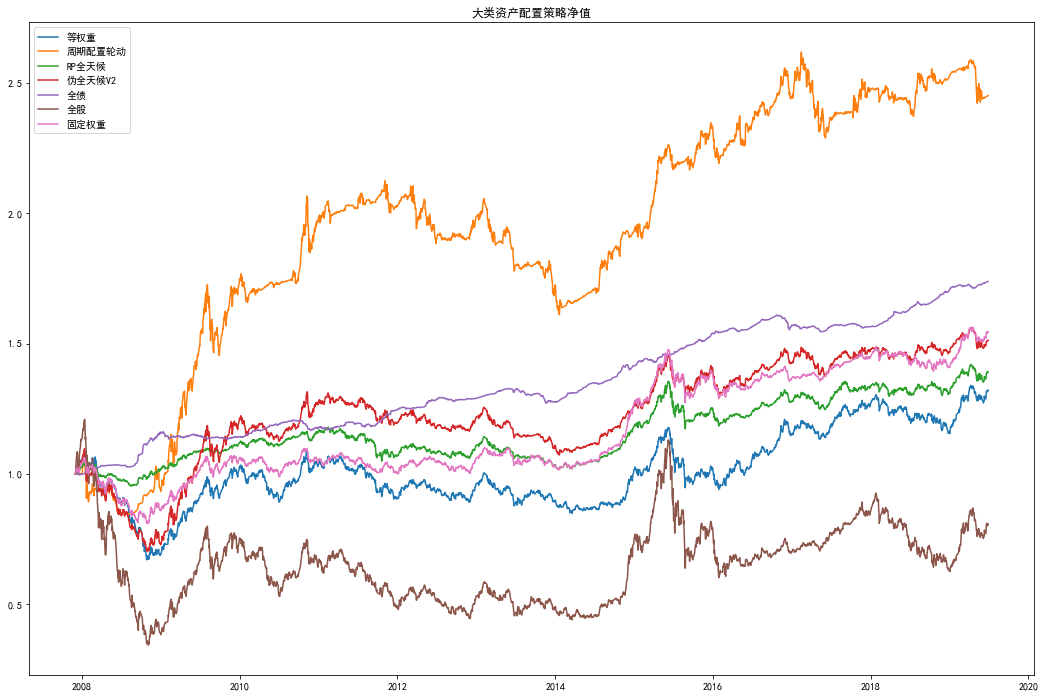

In [118]:
# 净值
plt.figure(figsize=(18,12))
plt.title('大类资产配置策略净值')
for key in EquitySeriesDict.keys():
    plt.plot(EquitySeriesDict[key]['equity_series'],label=key)
plt.legend(loc=0)
plt.show()

In [119]:
# # 超额净值
# plt.figure(figsize=(18,12))
# for method in methodList:
#     plt.plot(EquitySeriesDict[method]['equity_series']/EquitySeriesDict['等权重']['equity_series'],label=method)
# plt.legend(loc=0)
# plt.show()

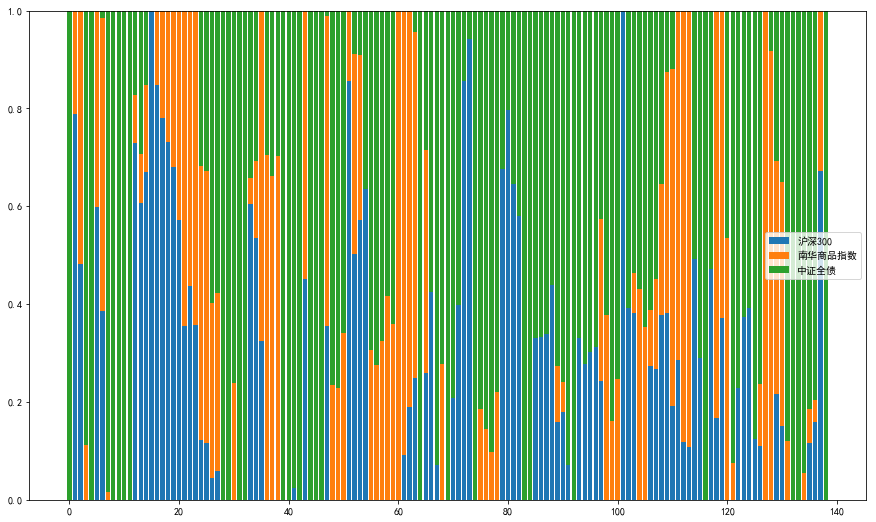

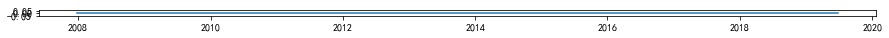

In [120]:
SDf = WeightDict['周期配置轮动']
plt.figure(figsize=(15,9))
plt.bar(range(len(SDf)),SDf['沪深300'], label='沪深300')
plt.bar(range(len(SDf)),SDf['南华商品指数'], bottom = SDf['沪深300'],label='南华商品指数')
plt.bar(range(len(SDf)),SDf['中证全债'], bottom = SDf['沪深300']+SDf['南华商品指数'],label='中证全债')
# plt.bar(range(len(SDf)),SDf['SGE黄金9999'], bottom = SDf['沪深300']+SDf['南华商品指数']+SDf['中证全债'],label='SGE黄金9999')
plt.legend(loc=0)
plt.show()

plt.figure(figsize=(15,0.1))
plt.plot(SDf.index,[0]*len(SDf))
plt.show()

In [121]:
print('轮动模型配置比例')
SDf.merge(MLcycleDf[['MLcycle']],left_index=True,right_index=True).groupby('MLcycle').mean().T.rename(columns=CycleDict).T

轮动模型配置比例


,沪深300,南华商品指数,中证全债
MLcycle,,,
经济下行 通胀下行,0.164341,0.114555,0.721104
经济下行 通胀上行,0.132757,0.241360,0.625883
经济上行 通胀下行,0.444453,0.200334,0.355213
经济上行 通胀上行,0.270411,0.353918,0.375670


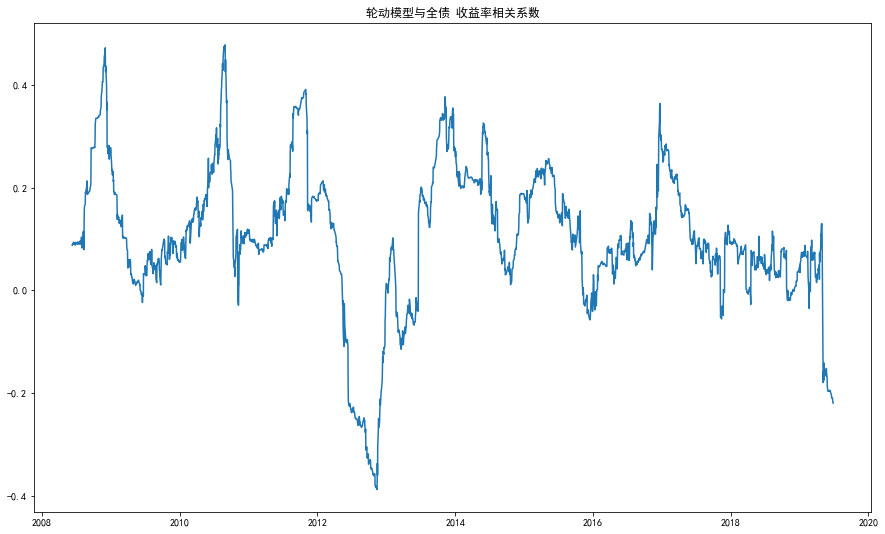

In [122]:
plt.figure(figsize=(15,9))
plt.title('轮动模型与全债 收益率相关系数')
plt.plot(EquitySeriesDict['周期配置轮动'].pct_change().rolling(126).corr(EquitySeriesDict['全债'].pct_change()))
plt.show()